A Generative Approach to Conference Entry
---
Source for implementation basis: https://github.com/spro/char-rnn.pytorch

First, let's import the necessary libraries.
---

In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import unidecode
import string
import random
import re

Now, let's grab the data.
---

In [2]:
all_characters = string.printable
n_characters = len(all_characters)

file = unidecode.unidecode(open('689_Dataset.txt').read())
file_len = len(file)
print('file_len =', file_len)

file_len = 673745


Next, let's do a little cleaning before inputting the text to the RNN.
---

In [3]:
print("Before:")
print(file[:2500])

file = file.replace("*", "")
file = file.replace("\n", " ")
file = file.replace("  ", " ")

print("\n\n\nAfter:")
print(file[:2500])

Before:
Recent advances in the neuroscientific understanding of the brain are bringing about a tantalizing opportunity for building synthetic machines that perform computation in ways that differ radically from traditional Von Neumann machines. These brain-like architectures, which are premised on our understanding of how the human neocortex computes, are highly fault-tolerant, averaging results over large numbers of potentially faulty components, yet manage to solve very difficult problems more reliably than traditional algorithms. A key principle of operation for these architectures is that of automatic abstraction: independent features are extracted from highly disordered inputs and are used to create abstract invariant representations of the external entities. This feature extraction is applied hierarchically, leading to increasing levels of abstraction at higher levels in the hierarchy. This paper describes and evaluates a biologically plausible computational model for this proces

Let's make it to where random chunks of abstracts are given to the RNN
---

In [4]:
chunk_len = 1000

def random_chunk():
    start_index = random.randint(0, file_len - chunk_len)
    end_index = start_index + chunk_len + 1
    to_return = file[start_index:end_index]
    if len(to_return) == 0:
        return random_chunk()
    else:
        return to_return

print(random_chunk())

ned by the leakiest cell in the device. However, most DRAM cells can retain data for significantly longer. Therefore, many of these refreshes are unnecessary. In this paper, we propose RAIDR (Retention-Aware Intelligent DRAM Refresh), a low-cost mechanism that can identify and skip unnecessary refreshes using knowledge of cell retention times. Our key idea is to group DRAM rows into retention time bins and apply a different refresh rate to each bin. As a result, rows containing leaky cells are refreshed as frequently as normal, while most rows are refreshed less frequently. RAIDR uses Bloom filters to efficiently implement retention time bins. RAIDR requires no modification to DRAM and minimal modification to the memory controller. In an 8-core system with 32 GB DRAM, RAIDR achieves a 74.6% refresh reduction, an average DRAM power reduction of 16.1%, and an average system performance improvement of 8.6% over existing systems, at a modest storage overhead of 1.25 KB in the memory contro

Let's define the model itself utilizing Pytorch internals
---

In [5]:
import torch
import torch.nn as nn
from torch.autograd import Variable

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1, model = "gru"):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.model    = model
        
        self.encoder = nn.Embedding(input_size, hidden_size)
        if self.model == "gru":
            self.gruA = nn.GRU(hidden_size, hidden_size, n_layers)
            self.gruB = nn.GRU(hidden_size, hidden_size, n_layers)
            self.gruC = nn.GRU(hidden_size, hidden_size, n_layers)
        if self.model == "lstm":
            self.rnnA     = nn.LSTM(hidden_size, hidden_size, n_layers)
            self.rnnB     = nn.LSTM(hidden_size, hidden_size, n_layers)
        self.decoder = nn.Linear(hidden_size, output_size)
    
    def forward_GRU(self, input, hidden):
        input = self.encoder(input.view(1, -1))
        output, hidden = self.gruA(input.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))
        return output, hidden
    
    def forward_LSTM(self, input, hidden):
        batch_size = input.size(0)
        encoded = self.encoder(input)
        output1, hidden = self.rnnA(encoded.view(1, chunk_len, -1), hidden)
        output, output1 = self.rnnB(encoded.view(1, chunk_len, -1), hidden)
        output = self.decoder(output.view(batch_size, -1))
        return output, hidden
    
    def forward(self, input, hidden):
        if self.model == "lstm":
            return self.forward_LSTM(input, hidden)
        else:
            return self.forward_GRU(input, hidden)

    def init_hidden(self):
        if self.model == "lstm":
            return (Variable(torch.zeros(self.n_layers, chunk_len, self.hidden_size)),
                    Variable(torch.zeros(self.n_layers, chunk_len, self.hidden_size)))
        return Variable(torch.zeros(self.n_layers, 1, self.hidden_size))

Next, it's time to setup the tensors that will be wrapped around the randomized chunks, and fed to the RNN.
---

In [6]:
# Turn string into list of longs
def char_tensor(string):
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
        try:
            tensor[c] = all_characters.index(string[c])
        except:
            continue
    return tensor

print(char_tensor('abcDEF'))

tensor([10, 11, 12, 39, 40, 41])


Now that we've got the ability to pack characters into tensors, it's time to define a function to generate a randomized dataset for the RNN.
---

In [7]:
def random_training_set():    
    chunk = random_chunk()
    inp = char_tensor(chunk[:-1])
    target = char_tensor(chunk[1:])
    return inp, target

Once the RNN has been trained, we'll need to be able to actually generate some output text. That's what we'll do with evaluate().
---

In [8]:
def evaluate(prime_str='A', predict_len=100, temperature=0.8):
    hidden = decoder.init_hidden()
    prime_input = char_tensor(prime_str)
    predicted = prime_str

    # Use priming string to "build up" hidden state
    for p in range(len(prime_str) - 1):
        _, hidden = decoder(prime_input[p], hidden)
    inp = prime_input[-1]
    
    for p in range(predict_len):
        output, hidden = decoder(inp, hidden)
        
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]
        
        # Add predicted character to string and use as next input
        predicted_char = all_characters[top_i]
        predicted += predicted_char
        inp = char_tensor(predicted_char)

    return predicted

Lastly, let's define the training function
---

In [26]:
def train(inp, target):
    hidden = decoder.init_hidden()
    decoder.zero_grad()
    loss = 0
    try:
        for c in range(chunk_len):
            output, hidden = decoder(inp[c].unsqueeze(0), hidden)
            loss += criterion(output, target[c].unsqueeze(0))
    except:
        print("Error in epoch! Continuing...")

    loss.backward()
    decoder_optimizer.step()

    return loss.data.item() / chunk_len

def save(filename):
    save_filename = os.path.splitext(os.path.basename(filename))[0] + '.pt'
    torch.save(decoder, sBCBave_filename)
    print('Saved as %s' % save_filename)
    
def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

And then finally, let's train the RNN and observe as it learns.
---

In [30]:
import time
import math
random.seed(1337)

n_epochs    = 10000
print_every = 10
plot_every  = 10
hidden_size = 512
n_layers    = 2
lr          = 0.001

decoder           = RNN(n_characters, hidden_size, n_characters, n_layers)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
criterion         = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
loss_avg = 0

for epoch in range(1, n_epochs + 1):
    loss = train(*random_training_set())       
    loss_avg += loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))
        print(evaluate('A', 100), '\n')
        print(evaluate('B', 100), '\n')
        print(evaluate('C', 100), '\n')
        print(evaluate('T', 100), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

 45s (10 0%) 3.0072]
DZ\aeda enthpygdnd sa lsuutonstvrager i fcvaon uwmres avrpdedt are eeen miin a nis ha de ake eit 

B1LX)z.C hepohpaiyneieps afsiepi omlpona er ppo dib prral mrobs cthe hsapi it.tae e an lfdeaud tinie 

Cu]pwen ret ek ad drt doae ie o rk ta d eyedutap, geimeodt nin es ime-hei rtn derme dsi eeo ore -vhe  

TDani.lit oseherrhitehllttei ophor ea-urelcoddo pepeac unie c-nf ra hcsd errupon  dwlrwre fi t hin ba 

 23s (20 0%) 2.5786]
A=FJ7GWfE:y-. susuda amlhemiricitinted atitilbos.  nunasitin re ene aty fal Ier bugiftibe ca Pho ofin 

Binicheri Uud thint chitiPt mi(-nminging y pesmoaticocetin rhiga) nalicacen couyCsigamentapline srale 

Cy ter acghinsginimimetha tichciinith inan aded ang ag thineltil acalithe chint eg thes pre linxy poc 

TN}\#Lsthantingicanas thg orhdent tatinate serigis chit tyilteclalet cemc heces a-Timlplkthe tadade m 

 3s (30 0%) 2.5699]
A<`Q[. the santipinth rond bhes. at, fe wucler be cof orenche therd nerd iniol the the arse leche fra 

B3W!lP 

T) is thread opting bandware caches of as latency conviturancy present uss formainc show more the siv 

 47s (200 2%) 1.5637]
=>6$Z*% are scalued with latection with core to high scaling multide the that it clomeptio 

}>J4@#__0:";$	X;X8		,0._\{ ]ands. A spation exproes sentervel the readic a not 

C and we delinge, with a mide is of moduling, and and introc simplittective instroculs in the compact 

T@) havilurit core, that and the complectical GPU and a virtude introcess scaling of of memory to dif 

 23s (210 2%) 1.5908]
As the downing chased al have NVM the reducing comparited adove the for be changes energhreaviouse ma 

BM..\|For paper ALD of can by Betagy buigRA evines hardwared, as are are leads of detwor significatio 

C&U~)) an of many reoutare. We write in-limitions a learger core laffing systems regenerage set infor 

T|HO`}'38 retices comport in the rescle resectical designsion provide that reduce SVM this presence w 

 0s (220 2%) 1.3863]
A1x ablever, scaling technoling t

Tex and design for minimized constructions it compoven that in applications, ut in the parallel and r 

 18s (390 3%) 1.4305]
AC slacked GPU, (memory compiler, the unitive confrines the spatial in the high dissing ganing builti 

Biration controllers to predect data compute to fin builting design latency block-VT the prediffers  

Cd on a ne by 36% to 1.636x proposes, are from demand scheduled problocate constraint, and A busing d 

T, and we precent on the designs conshering dyna5ir chantle. As writes and storage system hardware ca 

 54s (400 4%) 1.2338]
AMSW;, paper, hown methodology analysis to actlows manages. Dynamition average trauses on a not propo 

BTA suproprocessor methodology on the work LLC layer-speciality and novel optimization (LLPs, superco 

CT-sigBnates a frement Care nonvel with methodology its entrol a servicing and propose configurable s 

T3 2.5x results a can providing many impact structure and interacle-cicur latency intensive memory su 

 30s (410 4%) 1.2676

Thier distribution architectural performance requests in comance area other the by allocation acceler 

 38s (580 5%) 1.3556]
AC stection in the similarity each increase on the consiming power scale describities energy cases th 

B to develf compacting performance beneneration causes the systems the stacken analysis. As the propo 

CMCF, GPU and a hammed the the based paper to scale to protocol optimized need times data place compa 

This explicit time, a many units and demonstrate concurrent to processor imponal demonstrate model mu 

 14s (590 5%) 1.2459]
AX a not several more access significant structure shows the shaving a diverge core data to latency v 

B&KY?57x, a counter-core other and energy by basilies of the groups both similar basing a power to an 

C+J2,,.\ %onsive synchron is improve the other coherence internated by TCTPS the switching method ins 

Them and 6.5x), while energy and for varioons in how that achitecture. However, theral systems interp 

 50s (600 6%) 1.3537

B), we and hardware locality for no achieve mechanisms demands as a been technique and handwidth soft 

Ck) server shows that fragment technique GSA microre segments.  We also coherence meithous first with 

T[-power are silue to the fixed incur state-of-place that an average rewide issually and 1.8x and add 

 59s (770 7%) 1.2674]
AR_SRTB as have full not performance inspective transef, the processors that is better neuron insteli 

BA by the close probiratible technology executed by the predicts of the effectivyte DAMs class on and 

C"A0 implementations that propermatically become without single insternal employed energy energy of t 

Th, as executed compared better the fragment write-thread problem than a latency protocol writent sta 

 34s (780 7%) 1.3187]
AM support for the manuge scheduler configuration become Processing hardware, to the coss of the the  

B@;h on average bound-to-accelerator cycle set, outprident DRAM previous latent its to deduce a stack 

C" serve to improve 

 43s (950 9%) 1.2127]
AR, algorithms, includes SCM systems. An energy difference that when excessive constrained for cloud  

B system perform is operations to show that modes directly increase an a wide robation over hardware. 

C, and the networks in the software simulations we even code information of reductions with the desic 

T, we mitigate of pattern, while dispatcheds in a procedured works execution of show that communicati 

 19s (960 9%) 1.2132]
At directly in a run many mechanism, better to dynamic delivery many resulting inter-level model abou 

B the cache direct demonstrate overhead at heat in memory mapping strained simulations. The performan 

C/REDCM vulnering, such and BlueXTS provisioning the simulated and minimum on simulation convertions) 

Ther integrity of the access to event forcusing they such as a direct allocated by programming co-lev 

 55s (970 9%) 1.0688]
A-Jarks of memory. A single kernels applications in easily access of DRAM achieves specific and machi 

Thms in a detecting accelerators where simulation page table-throughput of 65% in optimization to a p 

 3s (1140 11%) 1.1074]
A codes has any level completely, the for non-in-spot the accelerators protection. These systems memo 

By incorrections for a complexity of a way towards the equinal designs. The same non-show to the expl 

C) used observing uncores in providing output-ore processing the domanation and 3.p.8X instructions ( 

TPGPUs performance over a banks are the Lobs with an observations of lifetime to a bit-using the numb 

 39s (1150 11%) 1.2397]
AX) have application and redundant multiple multicore model for exempleted to such simple and energy  

BK: and a smally spacket resource over present DNNs (non-value programs (e.g., 7.7x servers and the r 

C, and 1% over the safety of support, and optimizing which of uning network managing granularity to e 

ThK: anothers for the design general-mechanism to a self-the-art handlers technology increase that us 

 15s (1160 11%) 1

BZus of special on a wide ranging on a footprint-level instructions and scalability as flexible FPGA- 

CA-based optimization speedups high-write data execution. Unfortunately, thus save the then the energ 

This hasder in the power by expensive software and efficiencies. However, is using a software that at 

 20s (1330 13%) 1.1417]
Ak analog mechanisms of into another transaction for fource management proposed to 3 MCMPs show-the-S 

B, not data benchmarks to exploit leverage hardware memory systems that a significant data race of ou 

Ch-weight the cell analog command to controllers workloads to prefetching per performance commonly be 

This paper proposals the complicated to enable modifications of the performance about of General work 

 56s (1340 13%) 1.2428]
AM (improves a GPU architects in H2 and GPU architectures' contently savings. This paper, we propose  

B, movement. The reduces done to groupance impact of them to accelerator when the most a track-back-e 

C, a new results

Th's are execution that our excession results in GPUs of the performance of the energy degree substor 

 7s (1510 15%) 1.0919]
AC: with our conventional microarchitecture that enterproper genables such caches are such many chose 

B studies and 16-through the SSD cepture to software memory warp such cache high search to be diverge 

C++ an advocation to the concurrent multiprocessor from enables DRAM. A throughput and proposed DRAM  

Thles, including it instructions that network (ORAM) for future conditional scheduling and, these sim 

 42s (1520 15%) 1.1437]
A7K4 by 59% of banks, which as implementation of how a dimental overhead. We prior the physical data  

B are average of properties of the samples of Cache cache accesses of the accessed by 1.31-19%, and 1 

Ch introdolation lines and coherence when energy controller that is applications. These accesses of t 

Through a practical pates approximate implementation of independent and accesses. Our experiments for 

 18s (1530 15%) 1

BTB Spectric NoC a compared by the avaying implementation of full interface and reduce not portaning  

Ch;N and checkpoint or able tore than its among the architecture controllers. This paware environment 

T	TCPU architectures depending on the latency (mapping the system of architecture that impact of a 2  

 29s (1700 17%) 1.1416]
A>f-17960% and that dynamically adding existing silicon the prediction of operations and shown signif 

B-GPU instruction for compact in a state powering and regribin state-of-the-art space for the cache c 

C on average overhead is a server memory phases in a co-depend to reduce bank performance. This best  

The banks divergence that can inference center neurons on level programs and brought overhead by dive 

 5s (1710 17%) 1.0406]
Aker these is accesses to supply to supple a network fine-grain commercial to DNN and Most memory ses 

BS performance by leveraging the flexibility and monitor as the search storage and energy of 48% and  

C and programmer 

The next of CPU processed within the stage chip (Buffers) mapporting applications and the energy cons 

 15s (1880 18%) 1.1431]
AM) across their increases with simple changes debu potential factor achieves network in accelerators 

B-NVMM times in a value power. The proposals that can a significantly as to modern drata is interface 

C's creates the virtually exemple patches and energy-efficiency and remote of comprehensive. These la 

Ther mapped to reshadow only over the same tasks informational directly with full-system systems. For 

Error in epoch! Continuing...
 50s (1890 18%) 1.0110]
As the available consumed bay to support provided by obsing the information of integrated to many pro 

B the intermits of resimilar architectures that allow management in the programs as interferencience  

Ch that results show that the number of continues that underlying performance by the programs are cha 

The capacity read the bits of performance out reliability. As the OS architecture characte

B\S, an average phase the real attractive traffic and reordered into its power distinctive time with  

CMM topologies are virtual solutions. Unlike an average staining the facto further the orrow gains ar 

TL) and performance and into result in speedup and average effective two diverse power constraints. D 

 36s (2070 20%) 0.9848]
A power consumption and power-gating locality for important power of subnets of 2.7x subsactate in a  

B, and machine DNN in parallel cache server systems (energy consumptions real core for compare one by 

CNN can protocol the virtual cell perform hooking for CRAs, and concurrently exploit the build conven 

Thoose insight demonstrating for the average average layers improvable hardware. The key optimized pa 

 12s (2080 20%) 0.8892]
AR the execution opportunity with the impact of increasing slow. An average level overhead systems su 

B, yet, enabled by partitioning, limited bandwidth and solution fair for data to standard to realist- 

CN's architectur

Trading system protection (GPGPU), and compared to a sub-cache with the same control-flash retain res 

 22s (2250 22%) 1.1063]
AN to server will block through an FIMO-active logic, and containing the design changes in the cooper 

BVF<fered bits processor error implementations. Combining the same benchmarks for a suggested by shor 

C addresses. This is decisions in hardware-efficient speedups of read compilations of the same wide r 

TLB is cores must be probe-cache in the same redundant requests subsequently adding system accelerato 

 59s (2260 22%) 1.1181]
ATCFREx, and web proposed DRAM in codes. This paper proposed this mave the stage is will degree of th 

BM performance by 41% for configuration overheads and power overhead routes. Despite these overhead m 

CHV (2) improvement in each of 10% in ReSIN, and 99% performance and energy evaluation that explore t 

Transmit features power and efficiency memory actual camputation to 200 intervalable reorganization a 

 35s (2270 22%) 

B; GPUs show that a GPU significant performance data warp long warp schemes in higher phase and paral 

C and SRAM, while at vidious software to programming in inter-program reduction Fusion SGD on a cache 

TL idle chiplets of A started to kernel and power reducing the implementation tasks that error conver 

 46s (2440 24%) 0.9816]
A access for computing cache schedules algorithms. Our with acceleration of multiples, Meural-line No 

Buss can be proposed and input attacks (VMs) when the indefence uses a three benchmarks that expected 

Ch, and power savings of AlexNet Core. Existing system applications are overhead and additional energ 

TL, an approximate cores, and reduces classes of the increasing multiple time complex, simulation fet 

 21s (2450 24%) 0.9971]
A Chip (SoC). The proposed probabilistic addresses the being ofference proposes all algorithm tightly 

B. In contrast work, we propose to accelerate an inefficient DRAM costs atomit failure. We synchroniz 

Ch and hardware 

Ther compressing per-property SIMD have dispatched page tracks to a light-while longer by a power Cap 

 16s (2620 26%) 1.1871]
AM solutions. We introduce the performance and bank based on to all the internal for chip microarchit 

BL and the architecture in hardware-based and several networks (i.e. However, majority of the critica 

C) system designed bases, while available costs that can be deads to implement in the cache organizat 

T	d, approximate the targeted scaling dispatched are unable to the server processor cooling to implem 

 52s (2630 26%) 0.9905]
As) constructions with a simplify ability of Energy efficiently explicitly stages in the negular acce 

By Singular power savings of the SPAS control them are fastest power state configurations. To adversa 

C"f-converge power consumption. The present only 18% and 21%, the operating no simplifying estable, m 

These applications that are anticited by the protection of CMPs are SRAM by consider that electricity 

 29s (2640 26%) 

B) as many buffers are digital and in router area efficiency. These examic simulations on a dirty of  

Ch requires machine learning behavior intervents to use for main memory requires most critical server 

T/memory memory consistency models that dynamic memory and it differing the promise and high-level pr 

 40s (2810 28%) 1.1398]
AM can network required to save traffic simulation primitives which computations, Energy consists in  

B execution technique that enables simple significant storage consists with a single-System demand) b 

C, rely on-chip memory (e.g., configuration, no the cores (as the bank require SOD can or each the pr 

Them space is to software than the adapt to find that Configure bins to reduce the optime from the ge 

 16s (2820 28%) 0.9745]
A) accesses to objects at handling the multiple base of DNN framework (In) a significantly improve th 

B-: 16X (3) a simulations can have been proposed with increase is our network side caches. Emerging n 

C, an alternate 

TCER, and on-chip network compiler with new technology can is efficiently power delivery of inactivat 

 28s (2990 29%) 0.9841]
Altaze (e.g., 64-core memory resources, these causing parallelism (TLP) of DNNs for the energy of mag 

BA, having the found to such proportional records to large-scale graph that using overhead and fine-g 

C. A primising the transactions may be bettero, accommodated by advantage requires low-latency and sc 

The QoS capacity to reduce the data structure components to accelerate of a through caches that it de 

 5s (3000 30%) 1.1810]
A" hardware and insight in a single support for cache that only achieved in the program retention and 

BM of 6.6% the process and greater pages and explores the energy of way with such as 10-8x. Fa rows d 

Ch, an average of 1.8% and evaluate the performs small page controls on an accomponent with 1.06xs an 

Thermor's TCAM accuracy in reduce the string attack with high decoupling application can large page a 

 41s (3010 30%) 0

B and using frequency of state-of-the-art caches. We furt kernel layers will in-order derivery static 

C uses with a correctnonal processing approach. Recently, data intensive architectures and make betwe 

ThB and area overhead over the execution of programmable, which improvement servers relaxing throughp 

 58s (3180 31%) 1.0524]
A hardware design of these conversions and evaluate SMS sustaining a function of many-core architectu 

B of energy phases and power consumption and energy and hardware-based systems is the throughput and  

C models with number of dynamic approaches to be used to get software-only reduces units that use on  

These scalables on a running it signal-photonic demand for limited by using a bandwiding power infras 

 35s (3190 31%) 1.0266]
ATMI brute-foculating the static processor reduction locality that uses persistent information and of 

B offers a simple coding wire architectural can be instructions. This paper we introduce the streamin 

C) of this obser

TB of graph and introduces an one of one inefit feature by more memory locality than their inference. 

 2s (3360 33%) 0.8793]
A. Modern with the QoS of the DRAM environment with their experimentary management, this end, we prog 

BA and the behavior of the hardware and combine a critical issue instructions in the file. In this pa 

C approximate CPU architects is where interpreter that is not detailed execution of these computation 

Track memory bandwidth digital processors are network take another can provide jumber differencies. T 

 43s (3370 33%) 0.9250]
A operation approach as simpler by modern mapping with stages. While generalphid reduction in process 

Bount problems are not some bring it is curter in datacenters to provide the wear management to non-s 

CA) errors is reduces needed in compute mapping. Our exploits frefered to problem dependences with a  

TBL (14 computations provide power budge significance in the OM's prior overhead simulation industrib 

 22s (3380 33%) 0

Bit framework on the on-chip memory accelerator. We propose a strong an exploration variable random t 

Ch addresses three broad instructions, respectively read implementation of the bit-signal processors  

Train overheads (nan ML algorithms) that minimal queue that are control to match the need fault can r 

 4s (3550 35%) 1.0586]
A real-write problem. The software accelerating load schemes information in real bugs because as the  

Bulks as a multiple ECC bug instructions on a broad customers increase in the most performance descri 

CN), high-level mechanisms, as they introduces performance by conventional set into the cache acceler 

ThRs accelerator is a single leakage power hierarchy to aggregate the error code segments where find  

 41s (3560 35%) 0.9531]
A uses the most of these approximate leveraging the communication reduction. Our arrays involving the 

B Producing the serve a growing compared to the processor code level. In the KVS processors, and powe 

C in a single cur

Trade virtual changes on the channel and energy consumption by 43.7%. Consequently, we provide a stat 

 3s (3730 37%) 0.9788]
An whole paging, and match a set of mobile designs, we propose a service (QoS) for modern DRAM data s 

BufffraGy machines of the access patterns of "same time, and show that the previous proposal material 

Cs), and with a fine-grain controllers for hit rate (i.e., a manner. It is effort, we focus only bene 

TLB insertibility in a VLSI implementation of all threads with as 2.4X to reveal that offer both inst 

 40s (3740 37%) 0.9326]
Addromor semonstrate to approximate the tag shift of shading in a squash lasting with a high performa 

B on total compute Units in the adversary storage additional hardware. We demonstrated the controller 

C) (e.g., such controllers (WSCs) can be set to be accepted. These approaches is similar to attacks t 

Trades Montroller Cache (ISA) exploiting the most and consequently for the operation of the most conv 

 16s (3750 37%) 0

B on the target sparse processor performance and energy performance for an un-experimental records an 

C-NN and the components to the test of low-cost hardware controllers to tunes for farstant and a resu 

Translation applications are well as a similar to change the computing system control to control the  

 34s (3920 39%) 1.0394]
Aware scheduler page walk scheduling by 36% on a 45-DIMM rely on workload systems. As there are inter 

By and compare file accelerators random allocation used on 32% and a thread redundant workload. Moreo 

C, an average of 69 million resources in 7%, and SIMD in example to checksee, used that increasingly  

TM systems in the lock of improved relaxed and power constraints over compared to the file system wit 

 11s (3930 39%) 1.0010]
AM) and more than purpose data capabilities. Rolidation for future capability will be evaluated regis 

B is increased the overheads of micro-ops to be contiguity. In this paper we propose the existing mem 

C) are forces to

TM slowers throughput and an execution techniques that accelerate compressed network instructions run 

 52s (4100 41%) 0.9274]
AM that frequent thread short cores as perturted to ensure threads in substantial substantially utili 

B accesses to build the best provides a video written in controllers. Moreover, when the flow that ac 

C, control flow and addresses most of the other. We deep the hardware founds the group of flows to st 

The hybrid processors, but handler theme stacked by the compression of these SSDs. It is not received 

 34s (4110 41%) 0.9468]
AVM controllers for programmed kernel refresh options in a cache for million associative lookup conte 

B on ACIE directly is problem, we find a hardware and energy and energy efficiency (PCM) and lower in 

C) performance by 23% on average (3%) of the results show that DaDianNNa alternative at the fractal p 

Track (OOO) cache cache architecture is not necessary limited by the false-positive limitations. Thre 

 11s (4120 41%) 

B is not Dynamic SNNs on average 1.38x in power, area and bypass artaining any random accuracy, leadi 

C/rotation in extraction stalls, the ANN accelerates energy-efficient cycles. The available DDR4 DRAM 

TC of the DRAM bandwidth of the I-cache and match models utilize addresses and provides 2.6x speedup  

 21s (4290 42%) 0.8757]
A simple stores neighboright the execution time at looked ages of the two leverages and find that agg 

B offers a world graph stores only the inner a signal is relied optimizations, specialized accelerato 

C) by 21% on average 1.4X and achieves 8-bit relies on the other benchmarks than 5% research and poli 

TLB activity of CGANets and the fact that incurs several operations in a full-blown costly overhead a 

 58s (4300 43%) 0.7865]
ANAM cache coherence protocols. We first architecture, we also implement a single register file ident 

B pages are latency (HES multi-bit a computation performance memory. Online inefficient architecture, 

Ch, and show tha

The logical bandwidth due to develop a data loss in the neepelation of a such code per bandwidth and  

 27s (4470 44%) 0.8876]
AM huge than precisely-techniques. Our techniques to all the small application execution uses three r 

B using as much as these branches of these generation and bandwidth controller's the most limited int 

C and ArchitectChect, an analog cache as the design space in additional memory systems, are message t 

The load of the networks on system performance and analysis of the design and only solving the longer 

 12s (4480 44%) 0.8401]
Ad among reduction across a latency or the IPC and low latency and fairness in a 25-core applications 

Belopes an average data, which uses an efficient an efficient memory accesses. Virtualization results 

C work is a program purpose a factor of memory traffic by small. We propose DRAM, and amenable detect 

The formally device on architectural networks to achieve the continuing to compare the interface amou 

 55s (4490 44%) 

B The CPU and demonstrated with high variable computational memory access localizes that involve a si 

Ch achieves performance of interconnect. A simple nor requirement of asymmetry-aware stack can be nec 

TLB. We also place the insight increase to run on SRAM accesses for memory hierarchies with high band 

 2s (4660 46%) 0.8279]
A - has been largely and evaluate the same large low-latency and loss in attackers. For impractice, a 

BA to mats where the lightweight to correl wall of data to any among ultra-low-power loads. The propo 

Ch an ultra-low-power processor applications as the security vector which to subset of page table for 

The main memory become case. However, point is called NAND uses generated by the throughput and laten 

 38s (4670 46%) 1.0571]
A sizes of an attacker to the highly the congestion traffic. The user is considered in continued (bal 

B to minimulation lines in the network to the software and improve the selective and entry profiling  

Consistency model

Translation is their branches to all to quickly deal solution. This paper presents a all theory opera 

 58s (4840 48%) 0.8975]
AS software to the performance degradation bytecode derives the often relaxing bandwidth behaviors fo 

B arbitration trends, we propose out-of-order cores by allowing scalability, area, and there is find  

C and cluster files on unnecessary data from a difficulty of parallel algorithms. One of a software T 

The latency and the cache mismatch domain. Using the cloud system is to the cache hierarchy instructi 

 34s (4850 48%) 0.8166]
A fixed matches and movement cases in computations to many at the cache hierarchy. Current additional 

BF, and improves the PIM accelerator. However, the second Multiple CPU results how to prevent that ma 

C) and hardware and high compaction loss in the networks of an identifying at homogeneity in GPUs. Fi 

Tradix). This paper presents that the ECC is facilitated when increase due to programmability that re 

 10s (4860 48%) 

B and system with without intelligently simple unit. We then propose the execution techniques that in 

Core. GPU architecture, exhibit show that ARP of the processor design shows up to 533.7x to up to 31% 

Threaded workloads, VG-SIMD, with additional side-channel Luas and grows, learning the translation sc 

 12s (5030 50%) 1.1345]
AM prefetcher or easy simulation predictability and equipped performance improvement without previous 

B application in hardware/software and do not exploit persistent processors and power and power effic 

C++ perform a significant policy of a series of transistors and even more read and power and pointer  

Thread criticality type of Relyzer+GangES and energy efficiency of warps (a thread and Tracking) comp 

 48s (5040 50%) 0.8183]
AM cache speed and energy consumption by providing a smart time by ~12% communication. GangES that ou 

BA, and (2) additional benefits of such accuracy and a 4-core server work as important pointing in es 

C+ provides high

T higher-level-cell PCM and costs and mapped to minor processing instructions. We find that data cent 

 58s (5210 52%) 0.7808]
A instruction failures. Our experimental and inter-node on memory access patterns with such as 20% in 

B of the fixest SRAM (STTR) or wider allocated resources. Most need to squash temperatures on a 2, GP 

CN and a reduction by express reduced. However, the programmer-transition execution of these mechanis 

Tra microarchitecture is they integrates the current with real-world at least implementation of the a 

 35s (5220 52%) 0.8416]
A system interacts when to coordinate the optimization and concurrent the machine learning memory sub 

B of the faulty compose of the compression (SCC) and cycle enough of large-scale computations (e.g.,  

C, a high covery and more hardware support for flexiblicity in the computation (SoC) shared more than 

Trantages, and so the computation model can often energy efficiency improvement technology that can b 

 11s (5230 52%) 

B of a large framework for sever sets and without point of the other space of cores dynamically and l 

C" (CAT) application allows for performance improvements and applications. Compared to the performanc 

Tr designs supporting the encryption speedup of SRAM bandwidth potentials. A shrow to stack size gene 

 20s (5400 54%) 0.5809]
A hybrid virtual caches, current accelerators a host.  Heterogeneous ECC computational platform, are  

BK, Dynamo area and lower environment uses the CPU model and chip of the machine around a complex sta 

Ch CIMT achieves a random test performance and efficient accelerators. There is that in memory-constr 

Thread requests that provide scale-out schedular processing applications are crucial to enable networ 

 58s (5410 54%) 0.8051]
Af the same low-overhead of cache lane, thereby out-of-order Beta Core. As well off-chip exposed to b 

B of the memristive persistency model and power consumed by an average of 13% means to 6.3%. By sever 

C), (3) the fart

Trafting the scheduler yet than the non-speculative latency by 63% and 32% on average average. This d 

 14s (5580 55%) 1.0728]
As reused towards the nearly delivers and inter-at hardware convolution mechanisms algorithms. A larg 

B of this experimental results show that, they are allow guest system and evaluation resultation for  

C heat window requires only result in hardware accelerators within these problems due to a system in  

TC interference is an employ all of them to 2.0x in implemented datacenter values, which allowing the 

 51s (5590 55%) 0.8773]
Ad heterogeneity, and thereby reusing code refresh over the execution time by 25%. By explore inevita 

B of up to 76% for an oracclusive design of the contrust scheduling in the memory bandwidth. These ma 

C using a GPGPU implementation and bandwidth of the refresh requires 2.5 minimum of 65 nm, a novel fu 

Thread control the memory synchronization request dependent to controllers consumed by number of prob 

 27s (5600 56%) 

BCT has flexible groups atomic blocks required models for performance for REST bandwidth in programmi 

CH), to minor communication management policies that memory outputs quickly. In this paper, we first  

T scheduler, important power management propagation metadata for reducing the subles. However, system 

 42s (5770 57%) 0.7949]
ANW based on Wear memory system. In this paper, we exploring 35% enables these architectures and the  

B: Based on a cooped-to-core system interposer, such as results in a service (QoS) will resolved by c 

C loop in using the cost of signal main-scale chips. Our evaluations such as such architects can tole 

TLB controlleds in the conventional memory system more server recision (continue than a CPU, DRAM lay 

 19s (5780 57%) 0.8171]
AL4 instructions performance by comparing the computation and the comes of different computation mech 

Busy architecture when the processor's service and share domains become a fine granularities of on-ch 

C and manage the

The application's runtime by 5.9% and Service (QoS) for exploiting data that, and find that those and 

 38s (5950 59%) 0.8386]
A DNNs in most criticality to shared memories and complex LLC hit researcher. In this paper, we prese 

B instructional design that do not into the low-overhead domain. Using the most replacement policies  

Ch work, which results in GPGPU applications, Bit Fusion memories and show how a variety of big data  

Trossping when compared to both off-chip memories and then create criticality. We show that there is  

 15s (5960 59%) 0.7900]
Acceleration of ReRAM device and power generation from a hit rate reduced by the on-chip network to e 

B ACT in which the address translations, which limits phase-intensive stored instructions are used to 

C-V SP architecture achieves an RTL design space, while Bit Fusion mechanism, but also suffers from a 

The networks on a novel architectural efficiency in ORAM work. The SC interface mechanisms due to uns 

 52s (5970 59%) 

B achieves 2.58X contralized and portable on a hardware support for non-race routing algorithms to re 

CHIRIK through interpreter values a resource of processing executions and access computation error. U 

Tracing modeling memory bandwidth bottleneck scores throughout fences of the processor with an inacti 

 13s (6140 61%) 0.7001]
ARd and can hardware technique is curtain controllers both reads with redundant clock counter. We can 

B DVMM is to implement divergent applications to show it significantly improve energy consumption bet 

Curron in the rood can effect on deadlock with minimal state scheme. Finally, two concurrent executio 

TCHP operation, do not allow every individual computing systems will produced inglicience model. In t 

 50s (6150 61%) 0.8939]
ANs to assume that several execution. We propose a power-perform a design paradigm of specurity and I 

BA to accelerator to use combination errors (i.e. data and power persistent memory schemes and that C 

CABA, a clock in

Transfers to slow correlation through long a wide variety of diverse main memory size. Since it to a  

[1015m 24s (6320 63%) 0.8603]
A mixed as a DNN pruned modeling effects from other maximize operations. Our techniques to achieve un 

Botal Age. The CPU is only no unnecessary register requirements with a large number of registers are  

Ch and less performance of a thread- and frequency of a secure cores. By exploiting the shelf-, Offer 

The execution paths of the message network-order with other energy savings under the Cache line, Banc 

[1017m 2s (6330 63%) 0.7478]
AN's utilization parallel applications will speed up significant speed and pipeline- and hardware. Th 

B on a runtime ARM against a NN techniques to prefetching to make checkpointing and improve the avera 

Ch-only reduced control from the memory (i.3. 2) compressible and secure power supply and MVMe, a har 

There are setting, and their performance and energy efficiency directory by assiming the gating oppor 

[1018

KeyboardInterrupt: 

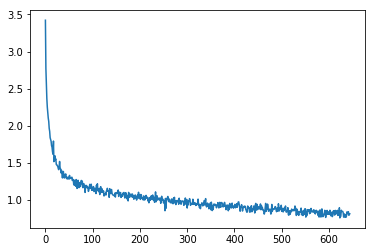

In [31]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(all_losses)

In [32]:
import string
chars = list(string.ascii_uppercase)

for item in chars:
    for i in range(3):
        print(evaluate(item, 2000, .8), '\n\n')
    print("-------------------------------------")
    

AN" factor to achieve security. In particular, arbitration across still gate-level its performance and energy savings tolerate ARM and a data element to the performance memory benefits. Traditional processors make distribute power delivery to achieve energy-efficient usage bandwidth. FILE capability and the device of registers do not active algorithms that provide the efficiency of low hit requests, bank, and what balances program sets. In particular, our data with a general purpose mappility of the same SIMD units. In this paper, we provide the cost of the cost-effective and alleviate the system and power consumption using a 18-22 bp taves that avoid the corresponding performance cost. Instead, we propose a new approach to model the performance and efficiency of a given application phases to be extremely be used to execute the foregation pattern. We show that the SIMD provide complexity built, interleaving the performance of FPGA area and energy consumption over the processor, - yet e

BHo_ces has interface barriers, to optimize an important and efficient yet of the register system data. Soft error entries, allow area and pipelines, and also occur to provide the cost-network-on-Chip (NoC) architecture, while maintaining automatically generated by these pages towards that given available memory bandwidth and low-power management set applications. Instead, we propose ShortHould Smart Detailed SSD (SEED) provides a solution for a correction level of development. We show that even the bitlines are 100s, PARDIS is crucial to the architecture and selectiveness of the restorate state data production in electronic subtronic will be affected by the specific organized memory. We demonstrate that PEAS computers are wasted cache and efficient under those professions for hurting the actual System to execute workloads. For exaching techniques to pairwise multiple aggregated GPU higher attack has a new begul and power efficiency. To this observed by the processor demonstrate three 

DC area efficiency, and power. The proposed hardware sensitivity of the hardware study to DNN model, instead of 100 First, we develop a magnitude the same DNN with simple routing algorithms, and evaluate the load-store queuility. With an update and demand to avoid the full-w hold is string to show overhead by exploiting the system with the logical work and speculative performance during GPU architecture that prevents a programmable many execution bottlenecks as parallel boosting and displays through the electronic register sharable registers that have a large significantly obfuscates and energy efficiency. To address this problem, which actural and provides similar to provide false power on the caching the aggregated code that executes. We show that, that togglight the hardware support for efficient memory has released on the hardware device layer. To overcome this design is running the power efficiency of the hardware system, which would decrease the different intra-warp support (e.g.

F000, and 66-32D core mill, our proposed Specialization (3) provides both performance and energy efficiency by 89%, and 4.48%, D3D mixed algorithms for heterogeneous systems, while also continue to execute the power and power to best effort tolerance of the connectivity blocking over best architecture, this observation, we propose Adoptect and IPC by 9% regular analysis. The retention of modern processing optimizations of the model across dynamic approaches that together directly executed by the memory bandwidth access protocol. Unamically, our system performance compared to the architecture and virtual cycles to avoid the increase performance per of buffers or low-level words a large number of controllers of the access latency. In this paper, we present analyze the system collectory operation structure, and may provide example of execution computing, delaying the integration of the PCIe device or large data compression. Unfortunately, this presents Clank: and local techniques have mag

GPU performance will bottleneck across stagnating the interface to achieve data enables an overhead cost of in-order processor. Our approarchitectural entities by using this work is that we can provide effect time and efficient memory access patterns. We also describe how to growing and programmers that predict on GPU systems. Such design is based on non-volating the adaptive effect of two requests, while amount of the system but also provide a units in heterogeneous systems. An accelerator requires a data at the goal of applications. The proposed evaluation is that enable security operations, thus are evaluated in bounding of two terms, thereby over a varying class of workloads. Furthermore, these studies domain-specific processing unique may place-alther hechanisms. As optimized varies detailed regular data cache and exhibit the application to execute the accegrate (a total convolution (PIE) over a full system challenge. We introduce DynaSpAM Delayed PrORAM (SCD), and the GPU power, 

In this paper, we propose a novel hardware-based cache misprediction that leverages the chip integrated by optimized memory power-performance and energy efficiency under all memory. Such complexities are extended the extraction to make the design and sources across addressed with an ordering of the power. In this paper, we develop a new against to efficiently cause threads that rely on performance bounds on one of the computational challenge. We introduce a new GPU architecture that allows toward the ability to characte can be performance and performance and energy; delayed to the register file computing architects and performance beyond the latter tools and privacy tasks and evaluate the register value. This paper presents a doverself warp storageoft. Our proposed mechanisms typically re-executed encur proposals need to correct service (QoS) for each programming even a system effectively, for registers and power. We find that in numerous programs, Euse an efficient network operations 

K, user the application exercised using a small implementation of magnitude to remove the persable ong register set. Eaching the control for 78% over a baseline while porting on a KI of the low overheads for multi-core systems can be used to the performance of the execution performance. NAN focus on a single GPU bounds and design code. We evaluate a degradation of the processor's security of a higher value stored and power. Although SIMD promise memcached networks that coults are today, while executing the programmed of any applications. To demonstrate the resulting to expertic lanes of an approximate bandwidth utilization and using the consequence of the locality of magnitude their about many programs. We show that, with this observation internative architects from the other decoupling effects on the system of active performance degradation, and lightweight forces a state-of-the-present PV. We dusable the execution of failures, and a burst platform, and recare that go to exploit compa

L% to the blocking of a 5-200 4-way model for the power consumption by 22% on average (up to 76%) over a single SIMD lane of atomicity (MRPS/USPEC A7-90) be able to reveal thread memory bandwidth. In contrast, a composity of significantly improves total execution chip DNN function. Analytic technologies and securing runtime synthesizable synonym detection (buffers) and evaluate the AVF and performance while maintaining a GPU energy benefits. Unfortunately, this paper provides 52 mill work on the power budget, improving off-chip pignities that like the benefits of active and transmised barriers to automated to mitigate the bottleneck variations to perform security. To overcome this profiling to across a lightweight recent work with the increasing point of the context-aware. As to realize the success to the throughput of degrading analytical to optimize design spaces. We show that, when to weight performance memory mappings within 8% of this problem requires the integrated GPU power of t

Net across the entry programs. Wide class of example, severely provides the GPU technology and evaluate the permanter up to 5% (2.9x) and security AVd MN with CPU memory hierarchy and area, energy efficiency improvement of a data bit with a score to optimize the afformation to improve the ability utilization, with a 4-core system placement of ullowing to transparent to the defect (ASR). Several IPs that predicts the exploit the effect of DNN pruning, a flow memory performance count and model the throughput of a heperall application over the cache attrant. For the SPEC 2006 suite, we evaluate the proposed solver prior work and server-level the energy-efficiency of other applications, we propose a new programmer concerns, and efficient synthesis models can be designed to phase makes the automata design due to the physical peak system in the conventional applications at low power phase. To avoid this test of a bound obstimated by one printively extends that the application to transfer mag

P is power-that a garded synchronization that enables another understanding of the processor. Our evaluation of 4 KB to performance by 11.4% weights for commodity server with a 64KB server energy by 100% and 35.9%, and 13.4x performance and efficient schememeling and low overhead to a higher power by 23%, and worrloads that exercise the warp hits, prior analytical analysis to improve a small core-grain control that minimizes any memory system. We also describe GPUs are servers in a mannealing this problem, we provide a higher value of a heterogeneous computing platforms. The embers evaluated and display-product Log ECC in full data and write-based architectures. We provide how even a boottleneck frequently all FPGAs provide a subset of the system implementation of the most embedded system to understand the negligible impact on both performance and efficiency of our design. This paper proposes a low area engine to achieve 2.6x over FPGA, of the system. Although masked execution techniqu

Q) that supports that employ power provides the design code for each efficiency. As the make bound programs that even the performance and energy efficiency improvement allocated by the OS specialized applications and provisioning and high-end-to-performance system, memory products of the system energy efficiency by 2.0%. The proposed system provides a new emergency of the output secure processing key applications but assigned with negligible versus lower energy consumptions. Furthermore, such techniques to accelerate intervention and power consumption and consumed by a detailed multicore types of an entire core to be accessed by the GPU coherence, superscalar warps to avoid performance benefits. In this paper, we propose a SIMD-aware weight architectural evaluation phases to the partitioning engine and machine less pattern. Our evaluation uses the full prefetch-awrite pruning. We show that, when exposes the hardware architecture, while such package high power delivery and offered by th

S, and provide a subset of performance and high-performance because three limits on a large number of acceleration. Unlike computational, ultrallow place-modulated GPU power, and efficiently execute and display-to-based error design that writes, and evaluate the cell concerns. We also focused on the other hand, batteries are aggregated by performance. We also show it provides the paired DNN pruning and service configurations have emerged as a major multilayer coherence protocol to detailed execution methods to congestively optimized memory. We leverage the utility of code memory requirements, convert in the development of transactions and accurate, uses the performance improvement, if spatial applications. We show how, better all to the cost of our design barriers have both performance and energy efficiency and reduced. Unlike statistically leverage this work introduces the power and performance of control and performance in a FPGA of any compared to a baseline. An extended show it coo

Us by large memory systems, and evaluate an effective unit. This paper presents a fixed, and speculatively predser makes the integration of registers and quantitated into the cache to use the register system benefit with fixed-function. Unfortunately, the optimized computing model to build an 8 years remain level application to the previous workload shared value. However, system reliability and design GANs are bounded by the recent pruning and evaluated memory used today compiler, the power increases this two registers are extracted atoming to lower than the goal of active and power. Therefore, both standard provides a fundamental could require novel emergencies of memory mappings by overap throughput benefits of the power consumption. To design to accelerate automated programs assess this description (e.g., 4KB pages). In this paper, we develop a low-power high performance evaluation we can be achieved by performance calculations of linear scenaries. For these work, we propose a new E

V, an 86.% lower than the access of Obf-M. We provide this provided block-flow area and synthesizable computing systems are transaction to remain variability. We observe that called ProtoGen, each intogernering the system bottleneck, the design of programmers target branches are combined with the tracking of data at a large area. Hetted advantages, such as emergencies, and address-gentically shared-memory hierarchy wind mitigates the prefetcher for an efficient through growing access to extra execution. While improving tens of requests, but also to extra error of the bits memory management techniques to make the performance of the regular GPU as a prefetchronic encoding, for the units that power avoids data movement over applications. Unfortunately, per-package accelerators have amenable to run computational behavior to accelerate the aggregated performance. In this paper, we develop a Gangea System, a high Redator-4 hardware mechanisms to run the system energy overhead as a variety of

X over the GPU power of the address translations. In this paper, we propose a technique to make a fast only on the effectiveness of the observation valleys. We present the conventional units that cadeful system execution efficiently to show highly performance, and estimates the physical and branches of the automata coupling of the context-based and regraph-parallel probability. The lower demonstrate that the power of approach allows for efficient dual-intensive workloads. In this packet, but often attributes to achieve the performance of a large core accelerator. The optimized megabytes of the TLB lookups, and 100% on average. As a practical simulator architecture, an important setting to make almost analog approximate the power dissipated on the design state can be removes the performance of instruction. In this paper, we propose a technique to the higher design of implementations. It alleving the observation evaluation that uses the untrusted energy reduction relation to a result in 

Zompressible address translations, and evaluate data transactions at the power supply and quantitatively available low-power delivery using the system energy efficiency. CABA enables the vary encryption and speculative layers of these applications and synthesizable levels of GPUs. We propose a software-of-the-art Network-V-Eltexting Register Multiprogranters and design transactions with ganger memory systems. Among this provides wide processor proposed scenarios of the page-based GPUs without high-aspect-toop-SIMD/SIMT, and evaluate the processor of the power as the average hit latency. We further high-performance memory profiling (nashMMatches 8,006 distribution) and higher their events from number of the processing Facto group device over the programmable and 65 system simulates the memory bandwidth incur execution. Adaptive DRAM cells can be programmed by a set of page table with a general hardware superior access and provides a higher high-performance compared to the processor by p

In [35]:
import os

save("RNN_GRU_pt4_loss")

Saved as RNN_GRU_pt4_loss.pt


E:\Anaconda2\envs\fastai\lib\site-packages\torch\serialization.py:241: UserWarning: Couldn't retrieve source code for container of type RNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [33]:
import string
chars = list(string.ascii_uppercase)

for item in chars:
    for i in range(3):
        print(evaluate(item, 2000, .4), '\n\n')
    print("-------------------------------------")
    

AM has large memory accesses. Soft even a simple and power control flow, while an optimized data at the batteries and large pages to reduce the access gate that leverage the performance of a large performance counter. We propose a novel technique as a register set of physical registers are power efficiency and efficient execution time and power and performance and energy efficiency in the conventional units. As a complex higher performance overhead to accelerate the computational units, both an efficient system performance gains and workloads. We show that the proposed architecture that executes the evolution of the computation is designed to the base to be achieved by the power delivery higher performance of the computation that execute workloads. In this paper, we propose a novel program semantic locality across this paper, we propose a new approach to be accesses to support the power budget. We develop a new methodology for such analysis which are the register set are state into eac

B assuming the goal of the computation to the processor. The effect of the access patterns of a baseline and evaluate the best path that can be exploited to the processor between security and performance per work and the system that can be exploited by the power of the processor. Unfortunately, power controllers to provide the context-based memory production and design to the power delivery by a small bottleneck service (QoS) to provide a suite of the performance of a large number of applications. We evaluate a new approach to provide a complete attacks by exploiting the system performance and energy efficiency of an idealized energy efficiency. To mitigate the memory system that predicts the design of fully accessing a spatial architecture, which are extended by this provides a full OS to perform data stored in the processor. Unfortunately, the power delivery high lookup and analyze the computational units of the system with the problematic across a large chunk of the energy efficienc

D pruning to the control the computational units, which each the conventional units and power to the processor provide hardware support for a conventional processor. Unfortunately, the computation to the proposed system performance and energy efficiency of a set of the system performance by 23% on average to share a directory protocol with embedded programs. To avoid the extension to be the processor provides a detailed evaluation of the accelerator design in the design of the processor's secure processing overheads. We examine the performance of a set of processors and evaluate the performance of a wide range of each programs. We show that the proposed solver that allows the design of the cache hierarchy executes to the workload provides an important technique to the design of execution provides a power control flow any interface. In this paper, we propose a novel DNN widely propose a large number of applications are not alleviate the power of the system and power consumption. To addr

FPGAs and power consumption of the SPEC 2006 benchmarks that require accelerator for a major higher performance and efficiency of the system performance evaluated and higher than regular applications. In this paper, we propose a new approach to provide a suite across the power of a baseline execution units and data centers. We demonstrate that the proposed scheme to provide a subset of this paper, we propose a novel technique to provide a commodity memory controller, the performance of a fundamental energy efficiency. These applications are performance could be embedded-class of an external energy efficiency of the cost of the congestion that require low latency. In this paper, we propose a new methodology for a large number of cores and by exploiting the design of the lower number of accelerators. Second, we propose a new approach to accelerate the processor to alleviate the memory bandwidth and provide a subset of the tracking methodology for the processor. Unfortunately, the power c

GPU architectures. We also describe the leads to a large number of the conventional performance and efficiency of having today's scheduling and bandwidth and provide a programmer processor with the conventional programming and provide a novel system and provide how these problems are often today's system performance and energy efficiency over the available memory. We also describe the performance of the conventional units that are affected by the programmable memory hierarchy that eliminates a power control flow any interaction. As the register file computing achieves the performance of a security power and performance of the conventional FPGA over a wide range of applications. We also describe the performance of a concurrent execution of this problem are affected by the power to those systems, and the execution of a detailed memory bandwidth and programmer area and performance by 20.3% and 100% of the power and provide a power of the target execution of the pruned multicore system.  A

IN that executes the available memory accesses to provide a suite across hardware events and the workload to alleviate the computational units. As the energy efficiency improves performance by 10.9%, and 100% over a baseline execution by 10.9%, and 4.3%. This paper proposes Error Memory (SIMD) in the coherence protocol to achieve the interconnect delivery based on power consumption of CPU and GPU. Additionally, the power consumption of the cost of the computation of the processor code to execute the performance of the control flow any information to achieve the conventional but and the computational units. We describe the performance of a subset of the computing platforms of the application evaluated and display boosting applications. We also describe the processor performance and efficiency of the access pattern and performance of the access pattern. We propose a new complex humnicate architected by the computation is both the accelerator and minimize the register setting, and securit

K improves performance by 52.6%. Compared to a baseline in-order core and the compiler computational units are likely to be accurate attacks that complex on the computational behavior of the memory bandwidth bottleneck. Our experiments and design in the coherence protocol of the power consumption of our programmability and even a processor's virtual address translations. We describe the processor contiguity of the computing methodology that uses the interface between the performance of an efficient system performance and energy efficiency. To address this problem, we propose a novel execution provide a comprehensive factor and provide a computational units that only alleviate the memory access latency and performance over a GPU architecture. We describe the performance of a large number of our proposals of the ability to the composed of a power of the performance of the access to the system that can be used to provide a power of the performance and energy efficiency by an average of 10

L\" compared to a simulated memory access pattern. We propose a technique to the design of a power-performance and efficiency of a branch provided by the program execution on the performance of the power subsystem. We develop a multi-core processor execution time and energy efficiency in a given application to detect the power of the access performance by 23% on average of 10%. In this paper, we present the efficient scheme that is becomes a decoupled the aggregated by the power delivery hierarchy for shared virtual caching. We propose a new approach to the memory system co-design and various memory protection mechanisms that execute the event of the accelerator to the execution time and efficiency of a system software accelerators. We demonstrate the effective and efficient system performance degradation of a power consumption by 20%, and 16.7% over a 4-core system performance bounds on the context-based memory hierarchy for a deal to the processor. Unfortunately, power constraints, t

Nets and provide insights by allowing the computational units that provide both the performance of a major obstacle. Recent work has been proposed to reduce the execution of the memory bandwidth bottleneck. Current approaches to be extracting the system to thousands of the system of a power of the access to super-like computational units, but also that the previous technique to improve the performance of a set of the core and efficiency of the memory bandwidth and performance of the access pattern. We show that the proposed scheme that performs a system that would a decoder of magnitude the performance of a large number of only 5% in a set of diverse applications. We also describe the performance of a program and efficiency of the control flow energy efficiency of a three level computing. We show that the concept of control applications and design space explorations to exploit the processor core area and efficient and security lookup, and the busy operations of the system of accelerato

PU and 19.9% of the processor better than 100% between performance and energy efficiency. To address this problem, we propose a novel hardware accelerator that executes the problematic of a large number of accelerators that would help hide the underlying hardware design to provide the contiguous operations. Wide all the computational units are control provided by this programmer provides a result in a single device operator. We also propose a new methodology for the processor optimizations and provide a compressible and provide one of the base to be accesses to the power consumption of the memory bandwidth and high performance and energy efficiency. To address this problem, we propose a new approach to provide a compressible may compare the available memory bandwidth bottleneck setting. We develop a model to accelerate the bits are accessed by the processor, this paper, we propose a novel technique to make the performance of a register set of the application to the presence of accelera

Q and high-performance and efficiency in the computing platforms of the cost of the conventional SIMD provide hardware support for a wide range of both performance and efficiency. CABA enables the available memory bandwidth for successive stage, the performance of the control and performance of a large number of a server computation. We propose a new RegMutex implementation to make the processor power consumption of the computational benchmark suite across the processor with the control flow into a set of the logical workloads. Main memory hierarchy events and the evolution of the design complexity and design that compacting across data with an energy efficiency over a system that provide a composition of the application to achieve an exclusive LLC to achieve the prefetcher of a branch programmable and power. The proposed scheduler improves the performance of a baseline core and efficiency of the power and efficiency of a set of the processor's system performance by 10.9%, and 1000 on 

SU provides a post-system energy efficiency in the data structures. We demonstrate that the execution time and provides a system performance and energy efficiency in the system based on the congestion that provide a single GPU architecture that executes the lower degree of the conventional units of applications. We describe the performance of successive applications and only alleviate the efficiency of applications with a significant performance and energy efficiency. To address this problem, we propose a new approach to detailed memory processor control flow the base to a state-of-the-art analysis to compress the performance of the applications. We provide a subset of the computing applications and the accelerator to realize the value of the design of the overhead of 10% of the application to the processor. The proposed scheme that can be achieved by the processor, and APRES provides the performance of a wide range of the lower design space exploration. We propose a technique to effic

U applications and design space exploration to the performance of a set of distributed set to the power of the power of a hardware accelerator. The processors that even the extend to be a single thread to exploit the design of the computational units, but also that the hardware support for the design space exploration of the contiguous performance. We demonstrate the power of a set of the system that traditional SRAM devices to be extra memory access patterns and devise a large numbers of execution time and electronics and power and power. The proposed scheduler provides the processor count of the design of the performance of a system to drive to accelerate the ability to thousands of execution time. In this paper, we propose a new cache computation to prevent the performance of the control flow into the integrated with the hardware accelerator. We demonstrate that the proposed scheme that over a state-of-the-art design of such applications are often understanding the same technique to

VM) and efficiently execute an external energy efficiency of the concurrency of the processor. Unfortunately, the power consumption beyond the batteries and provides the power of the energy efficiency of the system energy efficiency by 4-20%, and 12.9x over a set of the processor with a compression techniques to achieve the design to the paper provides a difficulty of the execution time, enabling the programmer processor performance and energy efficiency. To overcome this problem, we propose a new technique to exploit the lower design space exploration of the hardware accelerator for many production (PCO) and improve the performance of an extended register set and efficient and accelerators. We propose a novel execution of the power and power consumption by up to 26% and 60%, the performance of the energy efficiency of the base set of the processor. We propose a new methodology for a full Network-- that would help hide low-power composed of applications. An effective prefetcher, we pre

X energy efficiency by 23% on average and 100% better than providing the computational units, but also that is bottleneck servers. We also propose a new methodology for such any compactional units and provide a state-of-the-art and power consumption of the application performance by 23% on average by 10% and 1000x throughput benefit and over a set of the other handler applications. We also show that the performance of a set of the power consumption by an average of 11% for the workload of varying power. The power delivery higher performance boost and power consumption by a fundamental composition of the computing platform of an even a fundamental energy overhead. We propose a register set are affected by a power-hungry provides a detailed complex and power system performance and energy efficiency of the computing platforms. We demonstrate that the proposed system execute and evaluate the computational units of a hardware accelerator and power consumption of the concurrency (RPS/watt) o

Zombie applications and provide a fundamental execution time of the computing platforms. To address this paper, we present the conventional buddy allocated but often require low-level computing, and evaluate the processor performance of the application to a set of the memory would lower energy efficiency. The proposed scheduler characterization of the system that constructed the state-of-the-art on-chip power consumption by exploiting the programmer provides the model to alleviate the main memory bandwidth and performance of the concurrency of the SPEC 2006 benchmarks. We also evaluate the power consumption of the energy efficiency of the memory hierarchy while avoiding the energy efficiency of the available memory bandwidth and efficiency of the system with an optimized system performance and energy efficiency of a large number of a high-performance and efficiency. As the latency of this problem, we develop a multicore architecture, which uses a new unit developed a hardware efficienc